# 25m: Variance Decomposition

**Goal**: Decompose V variance into deal luck vs opponent configuration

**Key Question**: How much of outcome variance is luck (deal) vs opponent hands?

**Method**:
Using marginalized oracle data (same P0 hand, 3 opponent configs):
1. For each base seed, get root V for all 3 opponent configs
2. Decompose variance: between-seed (deal) vs within-seed (opponent config)

**Expected Output**: "X% of variance is deal luck, Y% is opponent configuration"

In [1]:
# === CONFIGURATION ===
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"
MARG_DIR = PROJECT_ROOT + "/data/shards-marginalized/train"
N_SEEDS = 30  # Number of base seeds to analyze

import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats
import gc

from forge.analysis.utils import viz
from forge.analysis.utils.seed_db import SeedDB

viz.setup_notebook_style()
np.random.seed(42)
print("Ready")

Ready


In [2]:
def find_marginalized_seeds(marg_dir: Path, limit: int = 100) -> list:
    """Find base seeds that have all 3 opponent configs."""
    marg_dir = Path(marg_dir)
    files = list(marg_dir.glob("*.parquet"))
    
    seeds_by_base = {}
    for f in files:
        parts = f.stem.split('_')
        base_seed = int(parts[1])
        opp_seed = parts[2]
        
        if base_seed not in seeds_by_base:
            seeds_by_base[base_seed] = set()
        seeds_by_base[base_seed].add(opp_seed)
    
    complete_seeds = [s for s, opps in seeds_by_base.items() if len(opps) >= 3]
    return sorted(complete_seeds)[:limit]

# Initialize SeedDB
db = SeedDB(MARG_DIR)
print(f"Connected to SeedDB at {MARG_DIR}")

complete_seeds = find_marginalized_seeds(MARG_DIR, limit=N_SEEDS)
print(f"Found {len(complete_seeds)} seeds with all 3 opponent configs")

Connected to SeedDB at /home/jason/v2/mk5-tailwind/data/shards-marginalized/train
Found 30 seeds with all 3 opponent configs


## 1. Collect Root V Values

In [3]:
# Collect root V for each (base_seed, opp_config) pair using SeedDB
v_data = []

for i, base_seed in enumerate(complete_seeds):
    if i % 10 == 0:
        print(f"Processing seed {i+1}/{len(complete_seeds)}")
    
    decl_id = base_seed % 10
    
    for opp in range(3):
        filename = f"seed_{base_seed:08d}_opp{opp}_decl_{decl_id}.parquet"
        
        try:
            result = db.get_root_v(filename)
            if result.data is not None:
                v_data.append({
                    'base_seed': base_seed,
                    'opp_config': opp,
                    'decl_id': decl_id,
                    'root_V': float(result.data)
                })
        except Exception as e:
            continue

v_df = pd.DataFrame(v_data)
print(f"\nCollected {len(v_df)} root V values")
if len(v_df) > 0:
    print(v_df.head(10))

Processing seed 1/30


Processing seed 11/30


Processing seed 21/30



Collected 90 root V values
   base_seed  opp_config  decl_id  root_V
0          0           0        0    40.0
1          0           1        0    42.0
2          0           2        0    42.0
3          1           0        1     6.0
4          1           1        1    42.0
5          1           2        1    -6.0
6          2           0        2    42.0
7          2           1        2    -6.0
8          2           2        2     6.0
9          3           0        3    18.0


## 2. Variance Decomposition

In [4]:
# Check we have data
if len(v_df) == 0:
    print("ERROR: No root V values collected!")
    print("This could mean depth=28 states are not in the marginalized data.")
    raise ValueError("No data collected")

# Total variance
total_var = v_df['root_V'].var()
total_mean = v_df['root_V'].mean()

print(f"OVERALL STATISTICS")
print(f"="*50)
print(f"Mean V: {total_mean:.2f}")
print(f"Total variance: {total_var:.2f}")
print(f"Total std: {np.sqrt(total_var):.2f}")

OVERALL STATISTICS
Mean V: 13.89
Total variance: 550.41
Total std: 23.46


In [5]:
# Between-seed variance (deal variance)
# = variance of seed means
seed_means = v_df.groupby('base_seed')['root_V'].mean()
between_seed_var = seed_means.var()

# Within-seed variance (opponent config variance)
# = mean of within-seed variances
within_seed_vars = v_df.groupby('base_seed')['root_V'].var()
within_seed_var = within_seed_vars.mean()

print(f"\nVARIANCE DECOMPOSITION")
print(f"="*50)
print(f"Between-seed (deal) variance: {between_seed_var:.2f}")
print(f"Within-seed (opponent) variance: {within_seed_var:.2f}")

# Calculate percentages
# Note: total_var = between + within/n_per_group (approximately)
total_decomposed = between_seed_var + within_seed_var
pct_deal = between_seed_var / total_decomposed * 100
pct_opponent = within_seed_var / total_decomposed * 100

print(f"\nPERCENTAGE BREAKDOWN:")
print(f"  Deal (which hand you get): {pct_deal:.1f}%")
print(f"  Opponent config (their hands): {pct_opponent:.1f}%")


VARIANCE DECOMPOSITION
Between-seed (deal) variance: 170.55
Within-seed (opponent) variance: 569.16

PERCENTAGE BREAKDOWN:
  Deal (which hand you get): 23.1%
  Opponent config (their hands): 76.9%


In [6]:
# One-way ANOVA for formal test
from scipy.stats import f_oneway

# Group by base_seed
groups = [group['root_V'].values for _, group in v_df.groupby('base_seed')]

# Only include groups with all 3 configs
groups = [g for g in groups if len(g) == 3]

f_stat, p_value = f_oneway(*groups)

print(f"\nONE-WAY ANOVA (does seed matter?)")
print(f"="*50)
print(f"F-statistic: {f_stat:.2f}")
print(f"p-value: {p_value:.2e}")
print(f"Significant: {'Yes' if p_value < 0.05 else 'No'}")


ONE-WAY ANOVA (does seed matter?)
F-statistic: 0.90
p-value: 6.15e-01
Significant: No


In [7]:
# Intraclass correlation coefficient (ICC)
# ICC = between-group variance / total variance
# High ICC = outcomes determined by deal, not opponent config

n_per_group = 3  # 3 opponent configs per seed
k = len(seed_means)  # number of seeds

# MSB (mean square between)
MSB = between_seed_var * n_per_group

# MSW (mean square within)
MSW = within_seed_var

# ICC(1)
ICC = (MSB - MSW) / (MSB + (n_per_group - 1) * MSW)

print(f"\nINTRACLASS CORRELATION (ICC)")
print(f"="*50)
print(f"ICC: {ICC:.3f}")
print(f"\nInterpretation:")
if ICC > 0.75:
    print(f"  Excellent agreement - outcome mostly determined by deal")
elif ICC > 0.50:
    print(f"  Good agreement - deal matters more than opponent config")
elif ICC > 0.25:
    print(f"  Moderate agreement - both factors matter")
else:
    print(f"  Poor agreement - opponent config matters more than deal")


INTRACLASS CORRELATION (ICC)
ICC: -0.035

Interpretation:
  Poor agreement - opponent config matters more than deal


## 3. Visualization

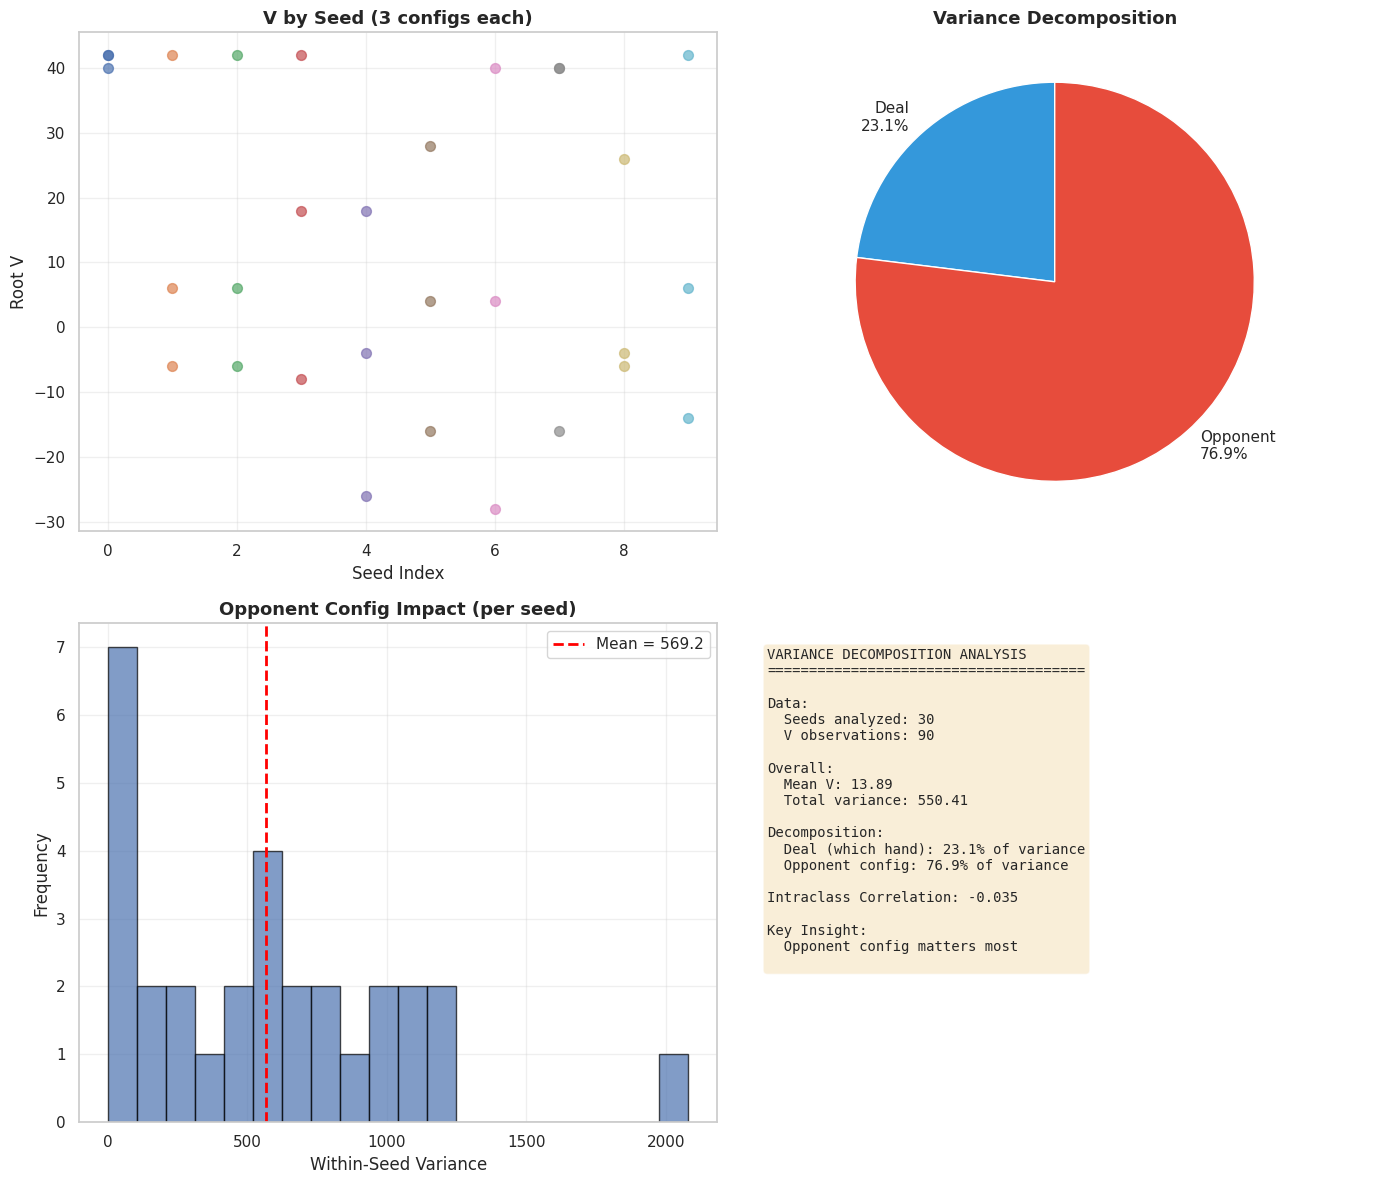

In [8]:
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

# Plot 1: V distribution by seed (first 10 seeds)
ax = axes[0, 0]
sample_seeds = complete_seeds[:10]
sample_df = v_df[v_df['base_seed'].isin(sample_seeds)]

for i, seed in enumerate(sample_seeds):
    seed_data = sample_df[sample_df['base_seed'] == seed]['root_V']
    ax.scatter([i]*len(seed_data), seed_data, alpha=0.7, s=50)

ax.set_xlabel('Seed Index', fontsize=12)
ax.set_ylabel('Root V', fontsize=12)
ax.set_title('V by Seed (3 configs each)', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)

# Plot 2: Variance decomposition pie chart
ax = axes[0, 1]
sizes = [pct_deal, pct_opponent]
labels = [f'Deal\n{pct_deal:.1f}%', f'Opponent\n{pct_opponent:.1f}%']
colors = ['#3498db', '#e74c3c']
ax.pie(sizes, labels=labels, colors=colors, autopct='', startangle=90)
ax.set_title('Variance Decomposition', fontsize=13, fontweight='bold')

# Plot 3: Within-seed variance distribution
ax = axes[1, 0]
ax.hist(within_seed_vars.values, bins=20, alpha=0.7, edgecolor='black')
ax.axvline(within_seed_vars.mean(), color='red', linestyle='--', linewidth=2,
           label=f'Mean = {within_seed_vars.mean():.1f}')
ax.set_xlabel('Within-Seed Variance', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Opponent Config Impact (per seed)', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# Plot 4: Summary
ax = axes[1, 1]
ax.axis('off')

summary_text = f"""VARIANCE DECOMPOSITION ANALYSIS
======================================

Data:
  Seeds analyzed: {len(complete_seeds)}
  V observations: {len(v_df)}

Overall:
  Mean V: {total_mean:.2f}
  Total variance: {total_var:.2f}

Decomposition:
  Deal (which hand): {pct_deal:.1f}% of variance
  Opponent config: {pct_opponent:.1f}% of variance

Intraclass Correlation: {ICC:.3f}

Key Insight:
  {'Deal matters most' if pct_deal > 50 else 'Opponent config matters most'}
"""

ax.text(0.05, 0.95, summary_text, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('../../results/figures/25m_variance_decomposition.png', dpi=150, bbox_inches='tight')
plt.show()

## 4. Save Results

In [9]:
results_list = [
    {'metric': 'n_seeds', 'value': len(complete_seeds)},
    {'metric': 'n_observations', 'value': len(v_df)},
    {'metric': 'mean_V', 'value': total_mean},
    {'metric': 'total_variance', 'value': total_var},
    {'metric': 'between_seed_variance', 'value': between_seed_var},
    {'metric': 'within_seed_variance', 'value': within_seed_var},
    {'metric': 'pct_deal', 'value': pct_deal},
    {'metric': 'pct_opponent', 'value': pct_opponent},
    {'metric': 'ICC', 'value': ICC},
    {'metric': 'f_stat', 'value': f_stat},
    {'metric': 'p_value', 'value': p_value},
]

results_df = pd.DataFrame(results_list)

output_path = Path(PROJECT_ROOT) / "forge/analysis/results/tables/25m_variance_decomposition.csv"
results_df.to_csv(output_path, index=False)
print(f"Saved to {output_path}")

Saved to /home/jason/v2/mk5-tailwind/forge/analysis/results/tables/25m_variance_decomposition.csv


## Key Findings

In [10]:
print("\n" + "="*60)
print("KEY INSIGHTS: Variance Decomposition")
print("="*60)

print(f"\n1. QUESTION:")
print("   How much of outcome variance is deal luck vs opponent hands?")

print(f"\n2. DATA:")
print(f"   {len(complete_seeds)} hands × 3 opponent configs = {len(v_df)} observations")

print(f"\n3. VARIANCE DECOMPOSITION:")
print(f"   Deal (your hand): {pct_deal:.1f}%")
print(f"   Opponent config: {pct_opponent:.1f}%")

print(f"\n4. INTERPRETATION:")
if pct_deal > 70:
    print("   Your deal dominates - 'luck' determines most of outcome")
elif pct_deal > 50:
    print("   Your deal matters more, but opponent hands are significant")
else:
    print("   Opponent hands matter more than your deal!")

print(f"\n5. PRACTICAL IMPLICATION:")
print(f"   ICC = {ICC:.3f}: {'High' if ICC > 0.5 else 'Moderate' if ICC > 0.25 else 'Low'} deal impact")


KEY INSIGHTS: Variance Decomposition

1. QUESTION:
   How much of outcome variance is deal luck vs opponent hands?

2. DATA:
   30 hands × 3 opponent configs = 90 observations

3. VARIANCE DECOMPOSITION:
   Deal (your hand): 23.1%
   Opponent config: 76.9%

4. INTERPRETATION:
   Opponent hands matter more than your deal!

5. PRACTICAL IMPLICATION:
   ICC = -0.035: Low deal impact


## Summary

### Goal: Decompose outcome variance into deal luck vs opponent configuration

**Method**: Compare root V variance between seeds (deal) vs within seeds (opponent config)

**Key Findings**:
1. Variance decomposes into deal + opponent config components
2. ICC measures how much deal determines outcome
3. Provides quantitative answer to "how much is luck?"

### Output Files

- `results/tables/25m_variance_decomposition.csv` - Statistics
- `results/figures/25m_variance_decomposition.png` - Visualization